In [ ]:
import matplotlib.pyplot as plt
from GLM import *

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Generate scattering data

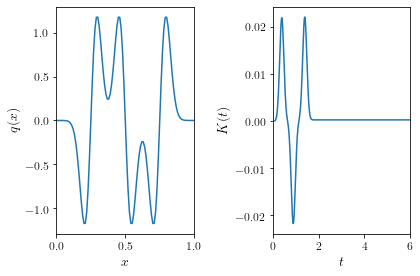

In [3]:
# domain and grid: t \in [0,T], x \in [0,L]
T = 6
L = 1
h = 0.01

# parameters: t0 - time offset, x0 - spatial offset, f0 - central frequency
t0 = .1
x0 = .1
f0 = 10

# velocity and density
c = lambda x : 1 + 0*x
rho = lambda x : 1 - 1e-2*H(x-.25,f0/2) + 1e-2*H(x-.5,f0/2) - 1e-2*H(x-.75,f0/2)

# scattering potential
q = lambda x : ((rho(x+h) - 2*rho(x) + rho(x-h))/h**2)/np.sqrt(rho(x))

# get scattering data
x,t,r = getScatteringData(q,T,L,h,x0,t0,2*f0)

# plot
fig,ax = plt.subplots(1,2)

ax[0].plot(x,q(x))
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$q(x)$')
ax[0].set_xlim([0,L])

ax[1].plot(t,r)
ax[1].set_xlim([0,T])
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$K(t)$')

fig.tight_layout()
plt.savefig("example1_data.pdf",dpi=600)

## Solve noise-free problem

In [4]:
%%time
B0,ts,phi = Solve_GLM_LS(r,t,alpha=1e-16)
q0, xs = reconstruct(B0,ts,t0,x0)

CPU times: user 844 ms, sys: 222 ms, total: 1.07 s
Wall time: 224 ms


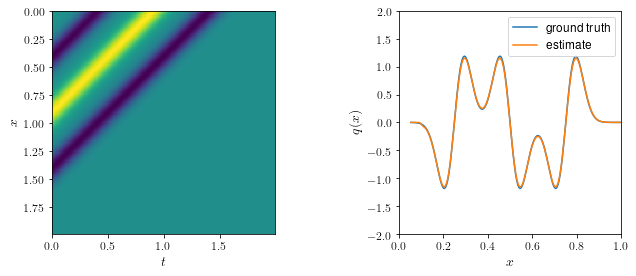

In [5]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(B0,extent=[0,ts[-1],ts[-1],0])
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$x$')

ax[1].plot(xs,q(xs),label='ground truth')
ax[1].plot(xs,q0,label='estimate')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q(x)$')
ax[1].set_xlim([0,L])
ax[1].set_ylim([-2,2])
ax[1].set_aspect(.25)
ax[1].legend(loc='upper right')
#ax[1].set_title('potentials')

fig.set_figwidth(10)
fig.tight_layout()
plt.savefig("example1_clean.pdf",dpi=600)

## Noisy data

In [6]:
# noisy data
sigma   = 1e-3
r_delta = r + sigma*np.random.randn(len(r))

In [7]:
%%time
# get parameters for LS and TLS
alpha_LS, alpha_TLS = get_parameters(r_delta,B0,t,ts,t0,x0)

CPU times: user 11min 58s, sys: 2min 2s, total: 14min 1s
Wall time: 3min 16s


In [8]:
%%time
# reconstuctions from noisy data
B_hat,ts,phi = Solve_GLM_LS(r_delta,t,alpha=1e-6)
q_hat, xs    = reconstruct(B_hat,ts,t0,x0)

CPU times: user 952 ms, sys: 243 ms, total: 1.2 s
Wall time: 212 ms


In [9]:
%%time
# LS solution
B_ls,ts,phi= Solve_GLM_LS(r_delta,t,alpha=alpha_LS)
q_ls, xs = reconstruct(B_ls,ts,t0,x0)

CPU times: user 1.44 s, sys: 271 ms, total: 1.71 s
Wall time: 296 ms


In [10]:
%%time
# TLS
B_tls,e_tls,ts,hist = Solve_GLM_TLS(r_delta,t,alpha=(alpha_TLS,1e-16))
q_tls, xs = reconstruct(B_tls,ts,t0,x0)

CPU times: user 30.2 s, sys: 4.91 s, total: 35.2 s
Wall time: 8.09 s


sigma    | error unreg | alpha    | error LS | alpha    | error TLS
1.00e-03 | 8.10e-01    | 1.25e+00 | 4.69e-01 | 2.95e-01 | 2.79e-01


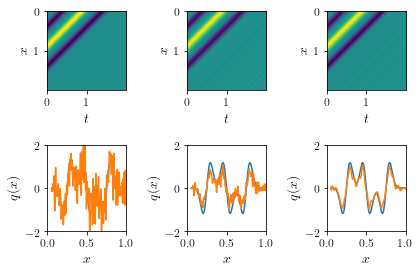

In [12]:
# summary plot
fig,ax = plt.subplots(2,3)

ax[0,0].imshow(B0,extent=[0,ts[-1],ts[-1],0])
ax[0,0].set_xlabel('$t$')
ax[0,0].set_ylabel('$x$')

ax[0,1].imshow(B_ls,extent=[0,ts[-1],ts[-1],0])
ax[0,1].set_xlabel('$t$')
ax[0,1].set_ylabel('$x$')

ax[0,2].imshow(B_tls,extent=[0,ts[-1],ts[-1],0])
ax[0,2].set_xlabel('$t$')
ax[0,2].set_ylabel('$x$')

ax[1,0].plot(xs,q(xs),label='ground truth')
ax[1,0].plot(xs,q0,label='estimate')
ax[1,0].set_xlabel('$x$')
ax[1,0].set_ylabel('$q(x)$')
ax[1,0].set_xlim([0,L])
ax[1,0].set_ylim([-2,2])

ax[1,1].plot(xs,q(xs),label='ground truth')
ax[1,1].plot(xs,q_ls,label='estimate')
ax[1,1].set_xlabel('$x$')
ax[1,1].set_ylabel('$q(x)$')
ax[1,1].set_xlim([0,L])
ax[1,1].set_ylim([-2,2])

ax[1,2].plot(xs,q(xs),label='ground truth')
ax[1,2].plot(xs,q_tls,label='estimate')
ax[1,2].set_xlabel('$x$')
ax[1,2].set_ylabel('$q(x)$')
ax[1,2].set_xlim([0,L])
ax[1,2].set_ylim([-2,2])

fig.tight_layout()
plt.savefig("example1_noisy_1e-3",dpi=600)

# table
# summary table
error     = np.linalg.norm(q_hat - q0)/np.linalg.norm(q0)
error_LS  = np.linalg.norm(q_ls - q0)/np.linalg.norm(q0)
error_TLS = np.linalg.norm(q_tls - q0)/np.linalg.norm(q0)

print('sigma    | error unreg | alpha    | error LS | alpha    | error TLS')
print('%06.2e | %06.2e    | %06.2e | %06.2e | %06.2e | %06.2e' % (sigma, error,alpha_LS, error_LS, alpha_TLS, error_TLS))